In [20]:
import glob
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import LeaveOneOut, train_test_split, KFold
from sklearn.svm import SVC

from micromlgen import port

In [21]:
def extract_mfcc(files, n_mfccs):
    # Dictionary to store mfcc values
    class_dict = {}
    for i in range(n_mfccs):
        name = "mfcc_" + str(i+1)
        class_dict[name] = []

    # Column for filename
    class_dict["filename"] = []
    
    # Loop through all the files for the class
    for filename in files:
        # Load audio file using librosa
        x, sr = librosa.load(filename)
        # Extract mfccs
        mfccs = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=n_mfccs)
        # Compute mean of the MFCC features along the time axis
        mfccs_mean = np.mean(mfccs.T, axis=0)
        # Turning results into dataframe
        for index, val in enumerate(mfccs_mean):
            col = "mfcc_" + str(index+1)
            class_dict[col].append(val)
        # Saving filename to dict
        class_dict["filename"].append(filename.split('/')[-2]+'_'+filename.split('/')[-1])

    return pd.DataFrame(class_dict)

In [22]:
def run_models(df):

    # Prep features and target
    features = df.drop(columns=["Class", "filename"])
    feature_names = features.columns
    target = df.Class
    class_labels = np.unique(target)
    cv = LeaveOneOut()

    # SVM
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.33)
    svm = SVC(kernel="linear")
    svm = svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    print(f"Train/test split accuracy SVM: {accuracy_score(y_test, y_pred)*100:.2f}%")
    print()
    
    svm = SVC(kernel="linear")
    actual_class = []
    predicted_class = []
    
    for train_index, test_index in cv.split(features):

        # Splitting into training and testing
        X_train, X_test = features.take(train_index), features.take(test_index)
        y_train, y_test = target[train_index], target[test_index]

        svm = svm.fit(X_train, y_train)
        y_pred = svm.predict(X_test)

        actual_class.append(y_test.item())
        predicted_class.append(y_pred[0])

    print(f"SVM Accuracy: {accuracy_score(actual_class, predicted_class)*100:.2f}%")
    plot_confusion_matrix(actual_class, predicted_class, "SVM", class_labels)
    svm_feature_importance = abs(svm.coef_[0])
    plot_feature_importance(svm_feature_importance, feature_names, "SVM")

    # Random Forest
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.33)
    rf = RandomForestClassifier()
    rf = rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    print(f"Train/test split accuracy RF: {accuracy_score(y_test, y_pred)*100:.2f}%")
    print()
    
    rf = RandomForestClassifier()
    actual_class = []
    predicted_class = []
    
    for train_index, test_index in cv.split(features):
        
        # Splitting into training and testing
        X_train, X_test = features.take(train_index), features.take(test_index)
        y_train, y_test = target[train_index], target[test_index]

        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)

        actual_class.append(y_test.item())
        predicted_class.append(y_pred[0])

    print(f"RF Accuracy: {accuracy_score(actual_class, predicted_class)*100:.2f}%")
    plot_confusion_matrix(actual_class, predicted_class, "Random Forest", class_labels)
    rf_feature_importance = rf.feature_importances_
    plot_feature_importance(rf_feature_importance, feature_names, "Random Forest")

    ## EXPORTING MODEL TO C CODE
    # rf_c_code = port(rf)
    # file_path = "MFCC_only_RF_model.c"
    # with open(file_path, "w") as file:
    #     file.write(rf_c_code)

    # XGBoost 
    # xgb = GradientBoostingClassifier()
    # actual_class = []
    # predicted_class = []
    
    # for train_index, test_index in cv.split(features):
        
    #     # Splitting into training and testing
    #     X_train, X_test = features.take(train_index), features.take(test_index)
    #     y_train, y_test = target[train_index], target[test_index]

    #     xgb.fit(X_train, y_train)
    #     y_pred = xgb.predict(X_test)

    #     actual_class.append(y_test.item())
    #     predicted_class.append(y_pred[0])

    # print(f"XGBoost Accuracy: {accuracy_score(actual_class, predicted_class)*100:.2f}%")
    # plot_confusion_matrix(actual_class, predicted_class, "XGBoost", class_labels)
    # xgb_feature_importance = xgb.feature_importances_
    # plot_feature_importance(xgb_feature_importance, feature_names, "XGBoost")

In [23]:
def plot_feature_importance(feature_importance, feature_names, model_name):
    
    # Sort features by importance
    sorted_idx = np.argsort(feature_importance)
    sorted_importance = feature_importance[sorted_idx]
    sorted_features = np.array(feature_names)[sorted_idx]

    # Create the bar chart
    plt.figure()
    plt.barh(sorted_features, sorted_importance, color='skyblue')
    plt.xlabel('Feature Importance')
    plt.title(f'Feature Importance for {model_name}')
    plt.show()

In [24]:
def plot_confusion_matrix(y_true, y_pred, model_name, class_labels):
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_name} (MFCCs only)')
    plt.show()

# MFCCs = 13
Train/test split accuracy SVM: 95.53%

SVM Accuracy: 98.33%


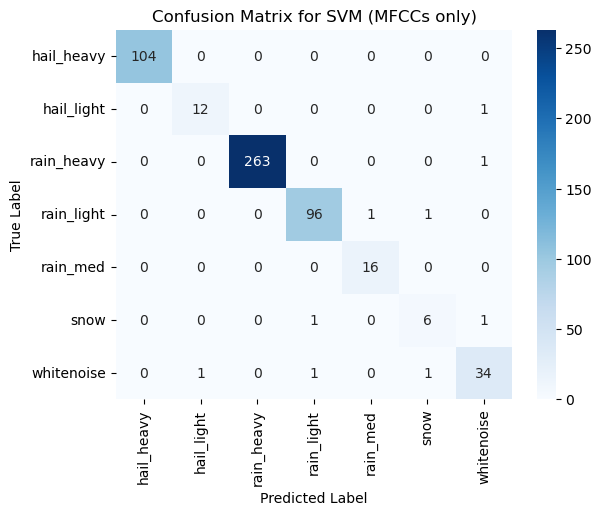

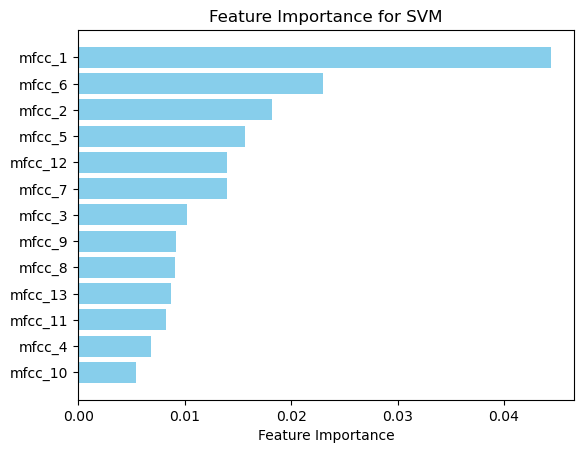

Train/test split accuracy RF: 97.77%

RF Accuracy: 97.96%


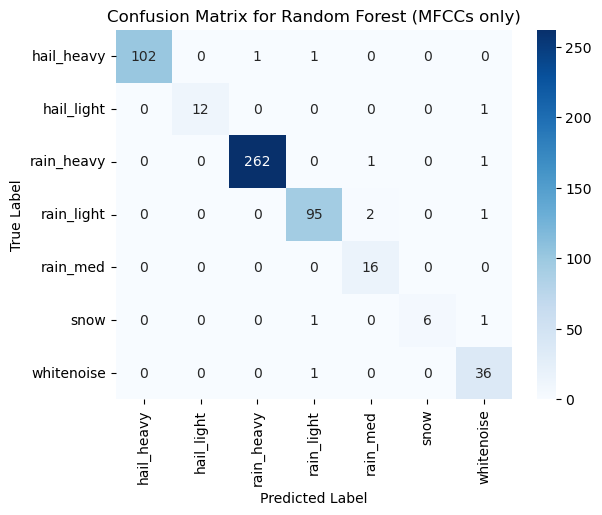

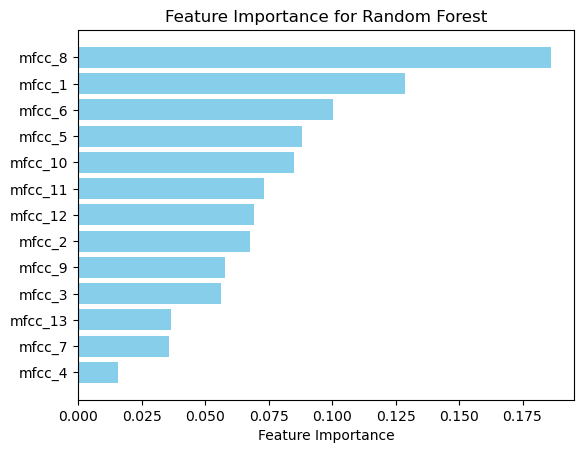

In [25]:
# Locate all audio files from new testing samples folder
all_audio_files = glob.glob("../microphone-sampling/TestingSamples2BatterySetup/*/*.WAV")

# Dictionary to store file names by class
class_dict = {}
for file in all_audio_files:
    file_class = file.split('/')[3]
    if file_class not in class_dict:
        class_dict[file_class] = []
    class_dict[file_class].append(file)

# Extracting MFFCs for each class, testing different # of MFFCs, and storing results in dataframe
potential_num_mfccs = np.arange(13,14)
for n_mfcc in potential_num_mfccs:
    all_class_dfs_list = []
    for key in class_dict:
        df = extract_mfcc(class_dict[key], n_mfcc)
        df["Class"] = key
        all_class_dfs_list.append(df)

    all_classes_df = pd.concat(all_class_dfs_list, ignore_index=True)
    print(f'# MFCCs = {n_mfcc}')
    run_models(all_classes_df)
    print()

In [26]:
# # Map string names to their integer labels used in predictions, drop irrelevant columns
# all_classes_df = pd.concat(all_class_dfs_list, ignore_index=True)
# mapping = {
#     string_label: index for index, string_label in enumerate(np.unique(all_classes_df["Class"]))
# }
# all_classes_df["label"] = all_classes_df["Class"].map(mapping)
# all_classes_df.drop(["filename", "Class"], axis=1, inplace=True)
# all_classes_df.to_csv("mfccs_only.csv", index=False)

In [27]:
# from collections import Counter
# print(Counter(all_classes_df.label))

In [28]:
# all_classes_df